In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
from torch.nn import functional as F
from torch.autograd import Variable

import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set(color_codes=True)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import h5py
import cv2
from scipy.stats import pearsonr#Pearson correlation coefficient
from sklearn.decomposition import randomized_svd
from scipy.signal import find_peaks
import datetime
import time
#import winsound#sound alarm when code finishes, only in windows
import pandas as pd
import seaborn as sns

from SemiNE.utils import *
from SemiNE.train import *
from chirpMB import *

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [2]:
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(1)
torch.backends.cudnn.deterministic=True
np.random.seed(1)
torch.manual_seed(1)    # reproducible
#
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_cpu=torch.device('cpu')
#device=torch.device('cpu')
EPOCH = 50
#BATCH_SIZE = 1000 #100
#LR = 0.05#original
LR=0.0001 # 1e-4
L2=0.0#L2=0.000001#L2 regularization

In [3]:
# for plot figures
plt.rcParams.update({'figure.max_open_warning': 0})
#Output matplotlib figure to SVG with text as text, not curves
plt.rcParams['svg.fonttype'] = 'none'
# axis spine
#use it like: adjust_spines(ax, ['left', 'bottom'])
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 2))  # outward by 2 points
            #spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine
    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

In [4]:
training_inputs = np.load('../data/fig7_training_inputs.npy')
training_set = np.load('../data/fig7_training_set.npy')
test_inputs = np.load('../data/fig7_test_inputs.npy')
test_set = np.load('../data/fig7_test_set.npy')
movie_bgr_h5 = np.load('../data/fig7_movie_bgr_h5.npy')
input_bg_mean_f   = np.mean(training_inputs[:13000],axis=(0,2,3,4),keepdims=True)/255
print (input_bg_mean_f)

[[[[[0.14519377]]]


  [[[0.14963487]]]]]


In [5]:
#split original training data into two parts, training loader: 2200, validation loader: 200
#make the dataset suitable for pytorch and semi-supervised learning
train_loader=[]
for ii in range(65):
    #neural data
    temp0=training_inputs[ii*200:ii*200+200]/255 -input_bg_mean_f #center the stimulus
    temp1=training_set[ii*200:ii*200+200]#100*200(neurons)
    #natural image data
    temp2=movie_bgr_h5[ii*250:ii*250+250] 
    temp=(temp0,temp1,temp2)
    #temp=(temp0,temp1)
    train_loader.append(temp)
#
temp0=training_inputs[13000:]/255 -input_bg_mean_f #center the stimulus
temp1=training_set[13000:]#200*200(neurons)
temp2=movie_bgr_h5[18000:19600]
#val_loader=(temp0,temp1)
val_loader=(temp0,temp1,temp2)
#
temp0=np.copy(test_inputs)/255 -input_bg_mean_f #center the stimulus
temp1=np.copy(test_set)#50*200(neurons)
temp2=movie_bgr_h5[19600:]
#test_loader=(temp0,temp1)
test_loader=(temp0,temp1,temp2)
#
print ('length of train_loader:')
print (len(train_loader))
print ('shape of train_loader[0][0]:')
print (train_loader[0][0].shape)
print ('shape of train_loader[0][1]:')
print (train_loader[0][1].shape)
print ('shape of train_loader[0][2]:')
print (train_loader[0][2].shape)
#
print ('shape of val_loader[0]:')
print (val_loader[0].shape)
print ('shape of val_loader[1]:')
print (val_loader[1].shape)
print ('shape of val_loader[2]:')
print (val_loader[2].shape)
#
print ('shape of test_loader[0]:')
print (test_loader[0].shape)
print ('shape of test_loader[1]:')
print (test_loader[1].shape)
print ('shape of test_loader[2]:')
print (test_loader[2].shape)

length of train_loader:
65
shape of train_loader[0][0]:
(200, 2, 50, 36, 32)
shape of train_loader[0][1]:
(200, 86)
shape of train_loader[0][2]:
(250, 2, 28, 28)
shape of val_loader[0]:
(3200, 2, 50, 36, 32)
shape of val_loader[1]:
(3200, 86)
shape of val_loader[2]:
(1600, 2, 28, 28)
shape of test_loader[0]:
(750, 2, 50, 36, 32)
shape of test_loader[1]:
(750, 86)
shape of test_loader[2]:
(400, 2, 28, 28)


In [6]:
del training_inputs,training_set,test_inputs,test_set

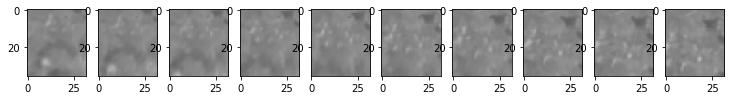

In [7]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(train_loader[30][0][ii][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

In [8]:
#visualize everything after making train and test loader
if num_cell>4:
    fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
    for ii in range(5):
        axes[ii].plot(train_loader[0][1][:,ii])
else:
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,1))
    axes.plot(train_loader[0][1][:,0])

NameError: name 'num_cell' is not defined

In [ ]:
#visualize everything after making train and test loader
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    axes[ii].imshow(test_loader[0][ii+45][0][0],cmap='gray',vmin=-0.5,vmax=0.5)
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

In [ ]:
#visualize everything after making train and test loader
if num_cell>4:
    fig, axes = plt.subplots(nrows=5, ncols=1,figsize=(10,5))
    for ii in range(5):
        axes[ii].plot(test_loader[1][:,ii])
else:
    fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(10,1))
    axes.plot(test_loader[1][:,0])

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=10,figsize=(12.5,2.5))
for ii in range(10):
    #axes[ii].imshow(train_loader[0][ii,0,...],cmap='gray',vmin=0,vmax=255)
    temp=np.zeros((28,28,3),np.uint8)
    temp[...,1:]=np.transpose(train_loader[0][2][ii],(1,2,0))[...,::-1]
    axes[ii].imshow(img_real2view(temp))
    axes[ii].grid(False)#axes[ii,jj].axis('tight')

In [ ]:
#preprocess: centered data
#sky_bg_mean_f   =(0.10539950580232095, 0.23792787064825932)
sky_bg_mean_f   = np.mean(movie_bgr_h5[:18000],axis=(0,2,3))/255
print (sky_bg_mean_f)

In [ ]:
#function: visualize conv0 weights
def Vis_conv3d_0(conv3d_0,temptitle):
    #UV channel
    weight_min=np.min(conv3d_0)
    weight_max=np.max(conv3d_0)
    if weight_max>(weight_min*(-1.0)):
        weight_min=weight_max*(-1.0)
    if weight_max<(weight_min*(-1.0)):
        weight_max=weight_min*(-1.0)
    #(outd,ind,height,weight)=conv3d_0.shape
    fig, axes = plt.subplots(nrows=int(len(conv3d_0)/8), ncols=8,figsize=(10, int(len(conv3d_0)/8)))
    for ii in range(int(len(conv3d_0)/8)):
        for jj in range(8):
            axes[ii,jj].imshow(conv3d_0[ii*8+jj,0,...],vmin=weight_min,vmax=weight_max,cmap='bwr')
            axes[ii,jj].set_xticks([]),axes[ii,jj].set_yticks([])
            if ii==0 and jj==0:
                axes[ii,jj].set_title(str(temptitle))
    #plt.tight_layout()
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.5])
    #fig.colorbar(im, cax=cbar_ax)
    #fig.savefig('./out/ae3D_4_wL2_initDefault_sky_conv3d_0.svg')

##  <font color='red'>Model architecture</font> 

In [9]:
class ModelSemiSL3d1(nn.Module):
    def __init__(self):
        super(ModelSemiSL3d1, self).__init__()
        #supervised
        self.numoffea=16 #number of features
        self.sizeoffea=28*24 #size of feature
        self.numofneuron=num_cell #number of neurons
        #spatial kernel, self.kernel_size=9 #odd number
        self.conv1_ss=nn.Parameter(torch.zeros(self.numoffea,2,1,9,9))
        std=1. / np.sqrt(2*1*9*9)
        self.conv1_ss.data.uniform_(-std*0.1, std*0.1)
        self.conv1_ss_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_ss_bias.data.uniform_(-std, std)
        #temporal kernel
        self.conv1_st=nn.Conv3d(self.numoffea,self.numoffea,kernel_size=(50,1,1),stride=1)
        #fc layer
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
        #autoencoder
        #self.ae_conv1_b=nn.Parameter(torch.zeros(self.numoffea)).requires_grad_(requires_grad=True)
        #stdv           = 1. / np.sqrt(2*9*9)
        #self.ae_conv1_b.data.uniform_(-stdv, stdv)
        #
        self.ae_dconv1 =nn.ConvTranspose3d(self.numoffea,2,kernel_size=(1,9,9),stride=1,padding=(0,4,4))
        self.ae_fc1    =nn.Linear(self.numoffea*28*28,self.numoffea*28*28)
        self.ae_dfc1   = nn.Linear(self.numoffea*28*28,self.numoffea*28*28)
        self.ae_encoder = nn.Sequential(
            #self.conv1, #16,28*28
            nn.ReLU(),
            Flatten3D(),
            self.ae_fc1,
            nn.ReLU(),
            GaussianNoise(sigma=1)
        )
        self.ae_decoder = nn.Sequential(
            self.ae_dfc1,
            nn.ReLU(),
            Unflatten3D(-1,self.numoffea,1,28,28),
            self.ae_dconv1, #2,28*28
            nn.Tanh())
    #
    def forward(self, x, z):
        #supervised
        encoded = F.conv3d(x, self.conv1_ss, bias=self.conv1_ss_bias,stride=1,padding=(0,0,0))
        encoded = self.conv1_st(encoded)
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        #autoencoder
        #z          = z.unsqueeze(2) 
        ae_encoded = F.conv3d(z, self.conv1_ss, bias=self.conv1_ss_bias,stride=1,padding=(0,4,4))
        ae_encoded = self.ae_encoder(ae_encoded)
        ae_decoded = self.ae_decoder(ae_encoded)
        #ae_decoded = ae_decoded.squeeze(2) 
        return encoded, ae_encoded, ae_decoded
#for visualization of RFs
class ModelSemiSL3d1_copy(nn.Module):
    def __init__(self,conv1_st_weight,conv1_st_bias,conv1_ss,conv1_ss_bias,fc1_weight,fc1_bias):
        super(ModelSemiSL3d1_copy, self).__init__()
        self.numoffea=16 #number of features
        self.sizeoffea=28*24 #size of feature
        self.numofneuron=num_cell #number of neurons
        #spatial kernel, self.kernel_size=9 #odd number
        self.conv1_ss=nn.Parameter(torch.zeros(self.numoffea,2,1,9,9))
        std=1. / np.sqrt(2*1*9*9)
        self.conv1_ss.data.uniform_(-std*0.1, std*0.1)
        self.conv1_ss_bias=nn.Parameter(torch.zeros(self.numoffea))
        self.conv1_ss_bias.data.uniform_(-std, std)
        #temporal kernel
        self.conv1_st=nn.Conv3d(self.numoffea,self.numoffea,kernel_size=(50,1,1),stride=1)
        #fc layer
        self.fc1=nn.Linear(self.numoffea*self.sizeoffea,self.numofneuron)
        #
        self.conv1_st.weight.data.copy_(conv1_st_weight.clone().detach())
        self.conv1_st.bias.data.copy_(conv1_st_bias.clone().detach())
        self.conv1_ss.data.copy_(conv1_ss.clone().detach())
        self.conv1_ss_bias.data.copy_(conv1_ss_bias.clone().detach())
        self.fc1.weight.data.copy_(fc1_weight.clone().detach())
        self.fc1.bias.data.copy_(fc1_bias.clone().detach())
    #
    def forward(self, x):
        encoded = F.conv3d(x, self.conv1_ss, bias=self.conv1_ss_bias,stride=1,padding=(0,0,0))
        encoded = self.conv1_st(encoded)
        encoded = encoded.view(-1,self.numoffea*self.sizeoffea)
        encoded = torch.exp(self.fc1(encoded))
        return encoded

##  <font color='red'>Different weights</font> 

In [ ]:
#Semi-supervised learning, ModelSemiSL2d1()
EPOCH=100 
LR = 1e-4
alpha1s = [1e2, 1e3, 1e4] # [1e0]
alpha2s = [1e1, 1e2, 1e3] # [1e1]
beta1s  = [1/4] # [1]
alpha3s = [1e4]
beta2s  = [1/16]
seeds   = [1]
lossweights=[0.7, 0.6, 0.5, 0.4, 0.3, 0.2] # [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0]
batch_num = 25 # len(train_loader)
#modeltrainloss=[]
modelvalloss=[]
modeltestloss=[]
for ii in range(len(alpha1s)):
    for jj in range(len(alpha2s)):
        for kk in range(len(lossweights)):
            #seedname=str(ii+1)
            #modelname=str(jj+1)
            torch.manual_seed(seeds[0])    # reproducible
            torch.cuda.manual_seed(seeds[0])
            tempmodel = ModelSemiSL3d1()
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            model_train(tempmodel,train_loader[:batch_num],optimizer,device,EPOCH,loss_SemiSL,sky_bg_mean_f,val_loader,\
                    alpha1=alpha1s[ii],alpha2=alpha2s[jj],\
                    beta1=beta1s[0],alpha3=alpha3s[0],beta2=beta2s[0],lossweight=lossweights[kk],earlystop=True,verbose=True) 
            #modeltrainloss.append(temp)
            #
            #torch.save(tempmodel.state_dict(),\
            #           './out/20210929_v4_ModelSemiSL3d1_ventral_upandlow_seed_'+seedname+'_weight_'+modelname+'.pth')
        
            temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
            modelvalloss.append(temp)
            CC,_=model_test(tempmodel,test_loader,device_cpu,sky_bg_mean_f,use_pad0_sti=False)
            modeltestloss.append(CC)
            del tempmodel
            torch.cuda.empty_cache()

2022-08-26 14:51:23.210206
Model:  ModelSemiSL3d1 |Epoch:  0 | train loss: 1.3145
Model:  ModelSemiSL3d1 |Epoch:  1 | train loss: 1.2434
Model:  ModelSemiSL3d1 |Epoch:  2 | train loss: 1.2186
Model:  ModelSemiSL3d1 |Epoch:  3 | train loss: 1.2006
Model:  ModelSemiSL3d1 |Epoch:  4 | train loss: 1.1938
Model:  ModelSemiSL3d1 |Epoch:  5 | train loss: 1.1855
Model:  ModelSemiSL3d1 |Epoch:  6 | train loss: 1.1804
Model:  ModelSemiSL3d1 |Epoch:  7 | train loss: 1.1756
Model:  ModelSemiSL3d1 |Epoch:  8 | train loss: 1.1719
Model:  ModelSemiSL3d1 |Epoch:  9 | train loss: 1.1685
Model:  ModelSemiSL3d1 |Epoch:  10 | train loss: 1.1651
Model:  ModelSemiSL3d1 |Epoch:  11 | train loss: 1.1622
Model:  ModelSemiSL3d1 |Epoch:  12 | train loss: 1.1591
Model:  ModelSemiSL3d1 |Epoch:  13 | train loss: 1.1560
Model:  ModelSemiSL3d1 |Epoch:  14 | train loss: 1.1533
Model:  ModelSemiSL3d1 |Epoch:  15 | train loss: 1.1507
Model:  ModelSemiSL3d1 |Epoch:  16 | train loss: 1.1476
Model:  ModelSemiSL3d1 |Epoch: 

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Overall pearson correlation coefficient:  0.15022784514428364  and p-value:  3.9958e-319
2022-08-26 16:06:40.389639
Model:  ModelSemiSL3d1 |Epoch:  0 | train loss: 1.3230
Model:  ModelSemiSL3d1 |Epoch:  1 | train loss: 1.2487
Model:  ModelSemiSL3d1 |Epoch:  2 | train loss: 1.2246
Model:  ModelSemiSL3d1 |Epoch:  3 | train loss: 1.2110
Model:  ModelSemiSL3d1 |Epoch:  4 | train loss: 1.1969
Model:  ModelSemiSL3d1 |Epoch:  5 | train loss: 1.1908
Model:  ModelSemiSL3d1 |Epoch:  6 | train loss: 1.1845
Model:  ModelSemiSL3d1 |Epoch:  7 | train loss: 1.1780
Model:  ModelSemiSL3d1 |Epoch:  8 | train loss: 1.1729
Model:  ModelSemiSL3d1 |Epoch:  9 | train loss: 1.1690
Model:  ModelSemiSL3d1 |Epoch:  10 | train loss: 1.1658
Model:  ModelSemiSL3d1 |Epoch:  11 | train loss: 1.1635
Model:  ModelSemiSL3d1 |Epoch:  12 | train loss: 1.1611
Model:  ModelSemiSL3d1 |Epoch:  13 | train loss: 1.1587
Model:  ModelSemiSL3d1 |Epoch:  14 | train loss: 1.1568
Model:  ModelSemiSL3d1 |Epoch:  15 | train loss: 1.155

## Plot: data size 

### lossweights=[0.4] 

(7, 10)
(7, 10)


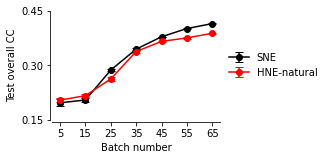

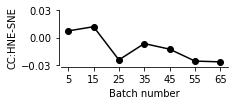

In [6]:
#test CC, bootstrap
#SNE
testloss_sne = np.load('out_result/20210929_tlag50_2_ModelSE3d1_ST_Exp_Ploss_test_loss_bnum_v4.npy')[:7,:]
print (testloss_sne.shape)

#HNE-Natural
testloss_hne_natural = np.load('out_result/20210929_ModelSemiSL3d1_ventral_upandlow_test_loss_bnum_v4_weight_8.npy')
print (testloss_hne_natural.shape)

#plot
testloss_sne_mean  =np.mean(testloss_sne, axis=1)
testloss_hne_natural_mean  =np.mean(testloss_hne_natural, axis=1)
val_losses = [testloss_sne, testloss_hne_natural]
means = [np.mean(ii,axis=1) for ii in val_losses]
means = np.array(means)
lowqs=np.zeros_like(means) #lower_quartile
higqs=np.zeros_like(means) #upper_quartile
for ii in range(len(means)):
    for jj in range(means.shape[1]):
        temp=val_losses[ii][jj,:]
        low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
        lowqs[ii,jj]  = means[ii,jj]-low_perc
        higqs[ii,jj]  =-means[ii,jj]+high_perc 
#
templabels=['5','15','25','35','45','55','65']
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(3,2))
ax.errorbar(np.arange(means.shape[1]),means[0,:], yerr=(lowqs[0,:],higqs[0,:]),\
            marker='o', color='k',linestyle='-', alpha=1, capsize=4, label='SNE')
ax.errorbar(np.arange(means.shape[1]),means[1,:], yerr=(lowqs[1,:],higqs[1,:]),\
            marker='o', color='r',linestyle='-', alpha=1, capsize=4, label='HNE-natural')
ax.set_xticks(np.arange(means.shape[1]).tolist())
ax.set_yticks([0.15,0.3,0.45])
ax.set_xticklabels(templabels)
ax.set_xlabel('Batch number')
ax.set_ylabel('Test overall CC')
adjust_spines(ax, ['left', 'bottom'])
ax.legend(loc='best')
handles, labels = ax.get_legend_handles_labels() 
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result/20210929_TestCCs_batchnumber2.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')

fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(3,1))
ax.plot(np.arange(means.shape[1]),testloss_hne_natural_mean - testloss_sne_mean,\
            marker='o', color='k',linestyle='-', alpha=1)
ax.set_xticks(np.arange(len(testloss_sne_mean)).tolist())
ax.set_yticks([-0.03, 0, 0.03])
ax.set_xticklabels(templabels)
ax.set_xlabel('Batch number')
ax.set_ylabel('CC:HNE-SNE')
adjust_spines(ax, ['left', 'bottom'])
#fig.savefig('out_result/20210929_TestCCdifference_batchnumber2.svg')

(7, 160)
(7, 160)


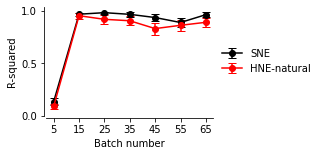

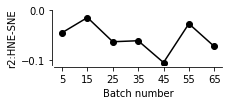

In [7]:
#R-squared, only green channel, bootstrap
cha = 0 # UV, G = 0, 1
#SNE
r2_sne = np.load('out_result/20210929_ModelSE3d1_Neu150_ST_Exp_ventral_conv0_fit_r2_bnum_v4.npy')
r2_sne = np.array(r2_sne).reshape(7,-1,2)[:7,:,cha]
print (r2_sne.shape)

#HNE-Natural
r2_hne_natural = np.load('out_result/20210929_ModelSemiSL3d1_ventral_upandlow_conv0_fit_r2_bnum_v4_weight_8.npy')
r2_hne_natural = np.array(r2_hne_natural).reshape(7,-1,2)[:,:,cha]
print (r2_hne_natural.shape)

#plot
r2_sne_mean  =np.mean(r2_sne, axis=1)
r2_hne_natural_mean  =np.mean(r2_hne_natural, axis=1)
val_losses = [r2_sne, r2_hne_natural]
means = [np.mean(ii,axis=1) for ii in val_losses]
means = np.array(means)
lowqs=np.zeros_like(means) #lower_quartile
higqs=np.zeros_like(means) #upper_quartile
for ii in range(len(means)):
    for jj in range(means.shape[1]):
        temp=val_losses[ii][jj,:]
        low_perc,high_perc=bootstrap('mean',temp,num_exp=10000,seed=66)
        lowqs[ii,jj]  = means[ii,jj]-low_perc
        higqs[ii,jj]  =-means[ii,jj]+high_perc 
#
templabels=['5','15','25','35','45','55','65']
fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(3,2))
ax.errorbar(np.arange(means.shape[1]),means[0,:], yerr=(lowqs[0,:],higqs[0,:]),\
            marker='o', color='k',linestyle='-', alpha=1, capsize=4, label='SNE')
ax.errorbar(np.arange(means.shape[1]),means[1,:], yerr=(lowqs[1,:],higqs[1,:]),\
            marker='o', color='r',linestyle='-', alpha=1, capsize=4, label='HNE-natural')
ax.set_xticks(np.arange(means.shape[1]).tolist())
ax.set_yticks([0,0.5,1])
ax.set_xticklabels(templabels)
ax.set_xlabel('Batch number')
ax.set_ylabel('R-squared')
adjust_spines(ax, ['left', 'bottom'])
ax.legend(loc='best')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc='center left',frameon=False, bbox_to_anchor=(1, 0.5))
#fig.savefig('out_result/20210929_r2s_batchnumber2.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')

fig,ax=plt.subplots(nrows=1, ncols=1,figsize=(3,1))
ax.plot(np.arange(means.shape[1]),r2_hne_natural_mean - r2_sne_mean,\
            marker='o', color='k',linestyle='-', alpha=1)
ax.set_xticks(np.arange(len(testloss_sne_mean)).tolist())
ax.set_yticks([-0.1, 0])
ax.set_xticklabels(templabels)
ax.set_xlabel('Batch number')
ax.set_ylabel('r2:HNE-SNE')
adjust_spines(ax, ['left', 'bottom'])
#fig.savefig('out_result/20210929_r2difference_batchnumber2.svg')

##  <font color='red'>Less training data</font> 
Using small batch numbers, everything else is fixed, only train the best weight, 10 seeds.

### small test

In [ ]:
#Semi-supervised learning, ModelSemiSL2d1()
# use the hyperparaters when cell number=86 and batch_num = 15 
EPOCH=100 
LR = 1e-4
alpha1s = [1e2] # [1e0]
alpha2s = [1e3] # [1e1]
beta1s  = [1/4] # [1]
alpha3s = [1e4]
beta2s  = [1/16]
seeds  =[1]
lossweights=[0.4] 
batch_nums = np.arange(5,16,10) #[int(len(train_loader)/4), int(len(train_loader)/2), int(len(train_loader)*3/4)]
#modeltrainloss=[]
modelvalloss=[]
modeltestloss=[]
for gg in range(len(batch_nums)):
    bnum = str(gg+1) #batch number
    for ii in range(len(seeds)):
        for jj in range(len(lossweights)):
            seedname=str(ii+1) #start from first seed
            modelname=str(jj+9) # modelname=1 and 9
            torch.manual_seed(seeds[ii])    
            torch.cuda.manual_seed(seeds[ii])
            tempmodel = ModelSemiSL3d1()
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            model_train(tempmodel,train_loader[:batch_nums[gg]],optimizer,device,EPOCH,loss_SemiSL,sky_bg_mean_f,val_loader,\
                    alpha1=alpha1s[0],alpha2=alpha2s[0],\
                    beta1=beta1s[0],alpha3=alpha3s[0],beta2=beta2s[0],lossweight=lossweights[jj],earlystop=True,verbose=False) 
            #torch.save(tempmodel.state_dict(),\
            #       './out/20210929_v4_ModelSemiSL3d1_ventral_upandlow_bnum_'+bnum+'_seed_'+seedname+'_weight_'+modelname+'.pth')

            temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
            modelvalloss.append(temp)
            CC,_=model_test(tempmodel,test_loader,device_cpu,sky_bg_mean_f,use_pad0_sti=False)
            modeltestloss.append(CC)
            del tempmodel
            torch.cuda.empty_cache()
            
modeltestloss=np.array(modeltestloss).reshape(len(bnums),10)
print (modeltestloss)
print (np.mean(modeltestloss,axis=1))

In [ ]:
#Semi-supervised learning, ModelSemiSL2d1()
# use the hyperparaters when cell number=86 and batch_num = 15 
EPOCH=100 
LR = 1e-4
alpha1s = [1e2] # [1e0]
alpha2s = [1e3] # [1e1]
beta1s  = [1/4] # [1]
alpha3s = [1e4]
beta2s  = [1/16]
seeds  =[1]
lossweights=[0.3] 
batch_nums = np.arange(25,36,10) #[int(len(train_loader)/4), int(len(train_loader)/2), int(len(train_loader)*3/4)]
#modeltrainloss=[]
modelvalloss=[]
modeltestloss=[]
for gg in range(len(batch_nums)):
    bnum = str(gg+1) #batch number
    for ii in range(len(seeds)):
        for jj in range(len(lossweights)):
            seedname=str(ii+1) #start from first seed
            modelname=str(jj+9) # modelname=1 and 9
            torch.manual_seed(seeds[ii])    
            torch.cuda.manual_seed(seeds[ii])
            tempmodel = ModelSemiSL3d1()
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            model_train(tempmodel,train_loader[:batch_nums[gg]],optimizer,device,EPOCH,loss_SemiSL,sky_bg_mean_f,val_loader,\
                    alpha1=alpha1s[0],alpha2=alpha2s[0],\
                    beta1=beta1s[0],alpha3=alpha3s[0],beta2=beta2s[0],lossweight=lossweights[jj],earlystop=True,verbose=False) 
            #torch.save(tempmodel.state_dict(),\
            #       './out/20210929_v4_ModelSemiSL3d1_ventral_upandlow_bnum_'+bnum+'_seed_'+seedname+'_weight_'+modelname+'.pth')

            temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
            modelvalloss.append(temp)
            CC,_=model_test(tempmodel,test_loader,device_cpu,sky_bg_mean_f,use_pad0_sti=False)
            modeltestloss.append(CC)
            del tempmodel
            torch.cuda.empty_cache()
            
modeltestloss=np.array(modeltestloss).reshape(len(bnums),10)
print (modeltestloss)
print (np.mean(modeltestloss,axis=1))

### training

#### lossweights=[0.4]

In [ ]:
#Semi-supervised learning, ModelSemiSL2d1()
# use the hyperparaters when cell number=86 and batch_num = 15 
EPOCH=100 
LR = 1e-4
alpha1s = [1e2] # [1e0]
alpha2s = [1e3] # [1e1]
beta1s  = [1/4] # [1]
alpha3s = [1e4]
beta2s  = [1/16]
seeds  =[1]
lossweights=[0.4] 
batch_nums = np.arange(5,66,10) #[int(len(train_loader)/4), int(len(train_loader)/2), int(len(train_loader)*3/4)]
#modeltrainloss=[]
modelvalloss=[]
for gg in range(len(batch_nums)):
    bnum = str(gg+1) #batch number
    for ii in range(len(seeds)):
        for jj in range(len(lossweights)):
            seedname=str(ii+1) #start from first seed
            modelname=str(jj+8) # modelname=1 and 8
            torch.manual_seed(seeds[ii])    
            torch.cuda.manual_seed(seeds[ii])
            tempmodel = ModelSemiSL3d1()
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            model_train(tempmodel,train_loader[:batch_nums[gg]],optimizer,device,EPOCH,loss_SemiSL,sky_bg_mean_f,val_loader,\
                    alpha1=alpha1s[0],alpha2=alpha2s[0],\
                    beta1=beta1s[0],alpha3=alpha3s[0],beta2=beta2s[0],lossweight=lossweights[jj],earlystop=True,verbose=False) 
            torch.save(tempmodel.state_dict(),\
                   './out/20210929_v4_ModelSemiSL3d1_ventral_upandlow_bnum_'+bnum+'_seed_'+seedname+'_weight_'+modelname+'.pth')

            temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
            modelvalloss.append(temp)
            del tempmodel
            torch.cuda.empty_cache()

2022-10-27 18:39:26.624823
Epoch: 35 val loss: 0.1487, finish training!
2022-10-27 18:40:17.357419
2022-10-27 18:40:31.656236
Epoch: 43 val loss: 0.1522, finish training!
2022-10-27 18:41:31.543599
2022-10-27 18:41:45.039260
Epoch: 38 val loss: 0.1471, finish training!
2022-10-27 18:42:36.588638
2022-10-27 18:42:49.829282
Epoch: 38 val loss: 0.1528, finish training!
2022-10-27 18:43:39.842167
2022-10-27 18:43:53.389184
Epoch: 38 val loss: 0.1477, finish training!
2022-10-27 18:44:43.935100
2022-10-27 18:44:57.861499
Epoch: 37 val loss: 0.1480, finish training!
2022-10-27 18:45:47.329186
2022-10-27 18:46:00.369964
Epoch: 38 val loss: 0.1545, finish training!
2022-10-27 18:46:52.202013
2022-10-27 18:47:05.409790
Epoch: 34 val loss: 0.1433, finish training!
2022-10-27 18:47:50.376554
2022-10-27 18:48:03.667436
Epoch: 35 val loss: 0.1437, finish training!
2022-10-27 18:48:49.442569
2022-10-27 18:49:02.573267
Epoch: 35 val loss: 0.1373, finish training!
2022-10-27 18:49:48.573423
2022-10-27

In [ ]:
#Semi-supervised learning, ModelSemiSL2d1()
# use the hyperparaters when cell number=86 and batch_num = 15 
EPOCH=100 
LR = 1e-4
alpha1s = [1e2] # [1e0]
alpha2s = [1e3] # [1e1]
beta1s  = [1/4] # [1]
alpha3s = [1e4]
beta2s  = [1/16]
seeds  =[1]
lossweights=[0.4] 
batch_nums = np.arange(5,16,10) #[int(len(train_loader)/4), int(len(train_loader)/2), int(len(train_loader)*3/4)]
#modeltrainloss=[]
modelvalloss=[]
for gg in range(len(batch_nums)):
    bnum = str(gg+1) #batch number
    for ii in range(len(seeds)):
        for jj in range(len(lossweights)):
            seedname=str(ii+1) #start from first seed
            modelname=str(jj+8) # modelname=1 and 8
            torch.manual_seed(seeds[ii])    
            torch.cuda.manual_seed(seeds[ii])
            tempmodel = ModelSemiSL3d1()
            optimizer = torch.optim.Adam(tempmodel.parameters(), lr=LR,weight_decay=0.0)
            model_train(tempmodel,train_loader[:batch_nums[gg]],optimizer,device,EPOCH,loss_SemiSL,sky_bg_mean_f,val_loader,\
                    alpha1=alpha1s[0],alpha2=alpha2s[0],\
                    beta1=beta1s[0],alpha3=alpha3s[0],beta2=beta2s[0],lossweight=lossweights[jj],earlystop=True,verbose=False) 
            torch.save(tempmodel.state_dict(),\
                   './out/20210929_v4_ModelSemiSL3d1_ventral_upandlow_bnum_'+bnum+'_seed_'+seedname+'_weight_'+modelname+'.pth')

            temp=model_val(tempmodel,val_loader,1,device_cpu,sky_bg_mean_f)
            modelvalloss.append(temp)
            del tempmodel
            torch.cuda.empty_cache()

2022-09-07 21:09:52.059748
Epoch: 35 val loss: 0.1487, finish training!
2022-09-07 21:10:35.406539
2022-09-07 21:10:48.232302
Epoch: 43 val loss: 0.1522, finish training!
2022-09-07 21:11:43.376472
2022-09-07 21:11:55.673097
Epoch: 38 val loss: 0.1471, finish training!
2022-09-07 21:12:43.076658
2022-09-07 21:12:55.125404
Epoch: 38 val loss: 0.1528, finish training!
2022-09-07 21:13:42.805895
2022-09-07 21:13:55.070270
Epoch: 38 val loss: 0.1477, finish training!
2022-09-07 21:14:43.450373
2022-09-07 21:14:55.500078
Epoch: 37 val loss: 0.1480, finish training!
2022-09-07 21:15:42.184046
2022-09-07 21:15:55.012987
Epoch: 38 val loss: 0.1545, finish training!
2022-09-07 21:16:43.092545
2022-09-07 21:16:55.288836
Epoch: 34 val loss: 0.1433, finish training!
2022-09-07 21:17:37.077691
2022-09-07 21:17:49.185741
Epoch: 35 val loss: 0.1437, finish training!
2022-09-07 21:18:32.907485
2022-09-07 21:18:45.278782
Epoch: 35 val loss: 0.1373, finish training!
2022-09-07 21:19:29.328005


Overall pearson correlation coefficient:  0.20580009289198464  and p-value:  0.0
Overall pearson correlation coefficient:  0.18586753822360413  and p-value:  0.0
Overall pearson correlation coefficient:  0.22359551331506136  and p-value:  0.0
Overall pearson correlation coefficient:  0.20286808998473246  and p-value:  0.0
Overall pearson correlation coefficient:  0.19847491929806949  and p-value:  0.0
Overall pearson correlation coefficient:  0.20200089311116917  and p-value:  0.0
Overall pearson correlation coefficient:  0.22150341685334068  and p-value:  0.0
Overall pearson correlation coefficient:  0.20724660336260747  and p-value:  0.0
Overall pearson correlation coefficient:  0.1955065398343295  and p-value:  0.0
Overall pearson correlation coefficient:  0.19910640240409805  and p-value:  0.0
Overall pearson correlation coefficient:  0.22723589787840226  and p-value:  0.0
Overall pearson correlation coefficient:  0.23041034823463574  and p-value:  0.0
Overall pearson correlation c

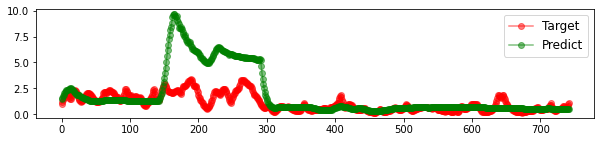

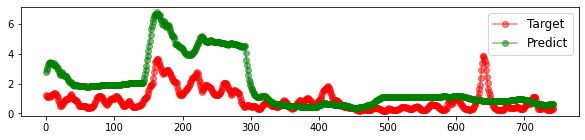

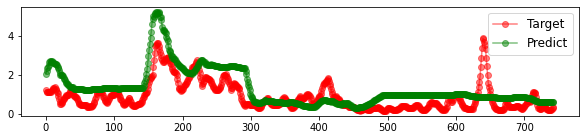

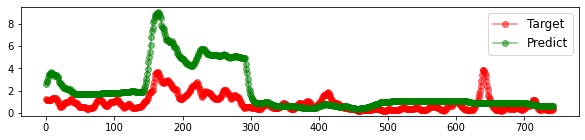

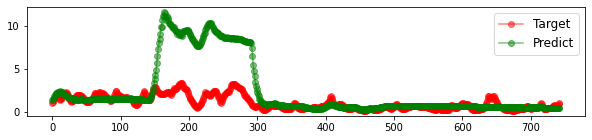

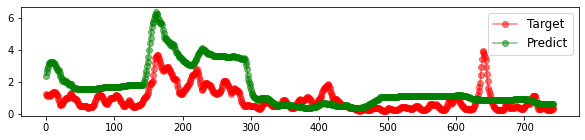

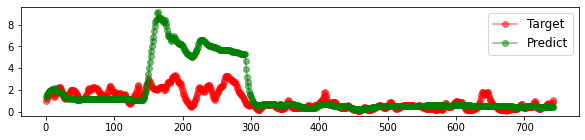

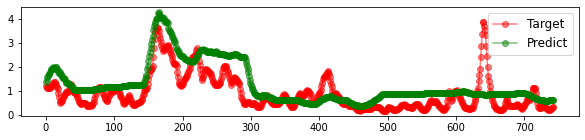

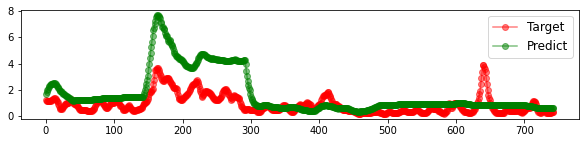

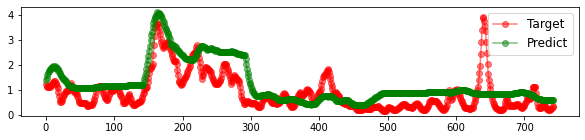

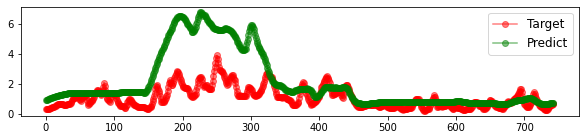

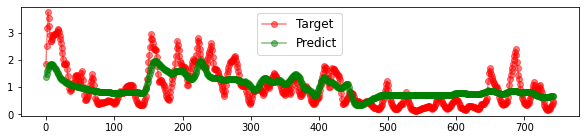

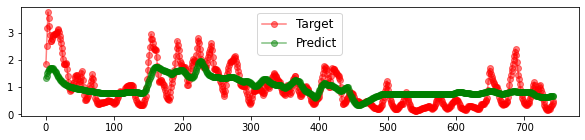

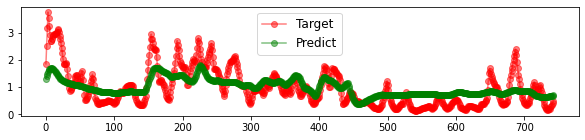

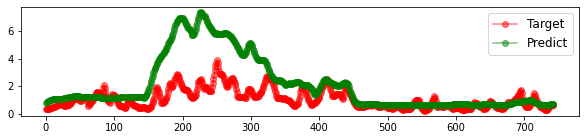

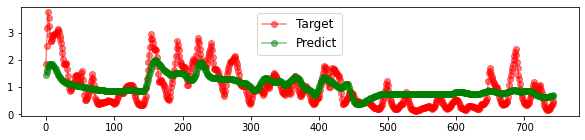

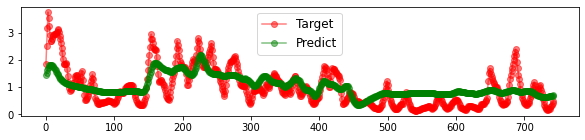

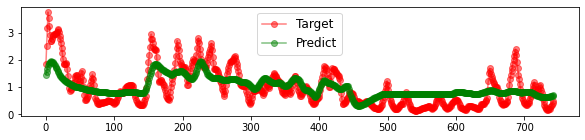

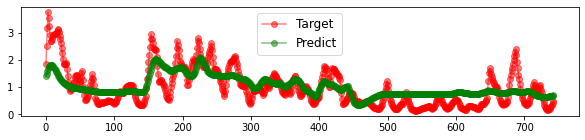

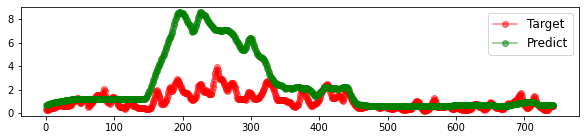

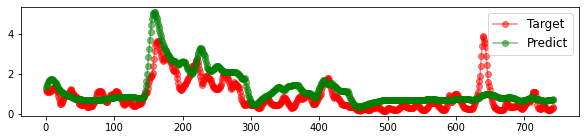

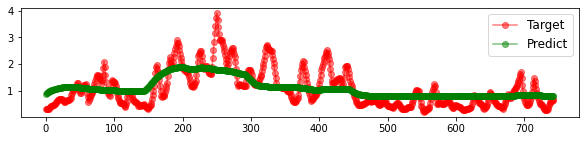

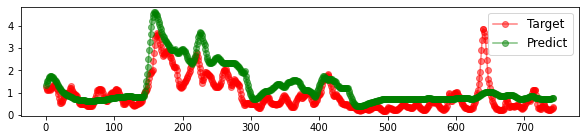

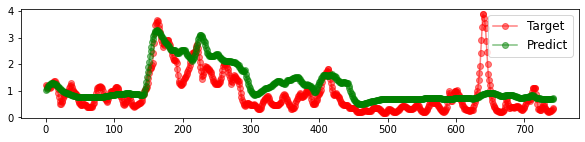

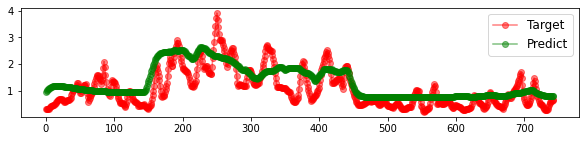

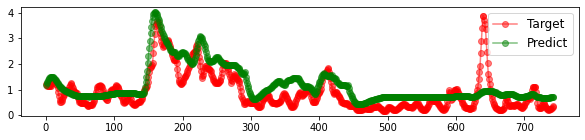

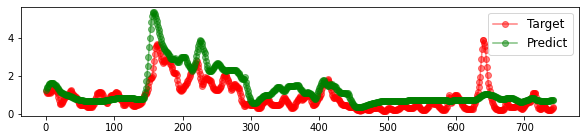

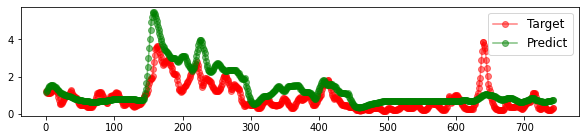

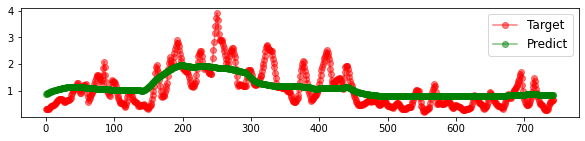

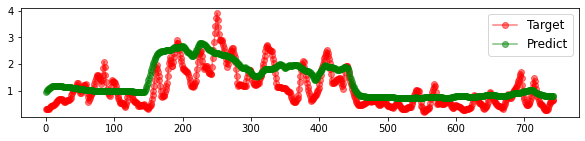

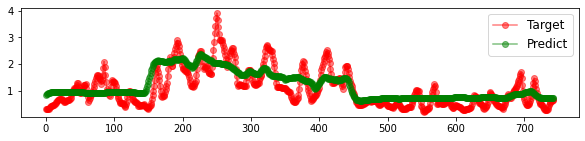

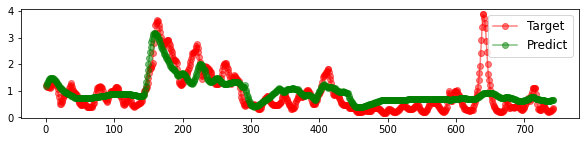

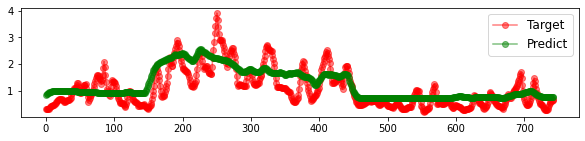

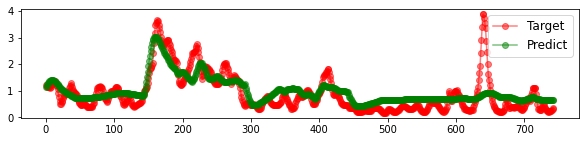

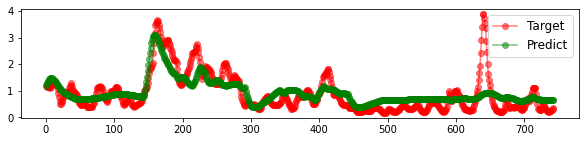

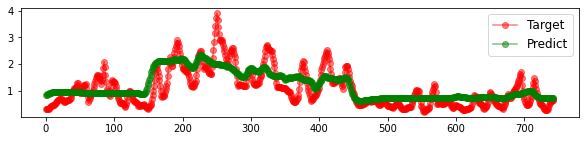

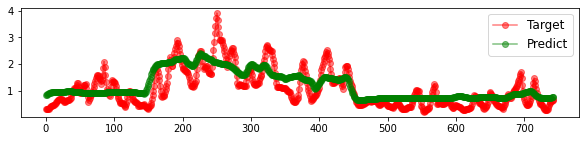

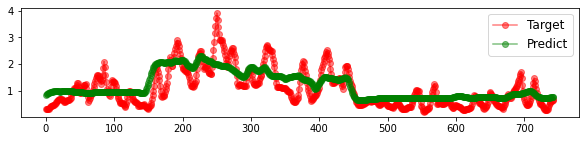

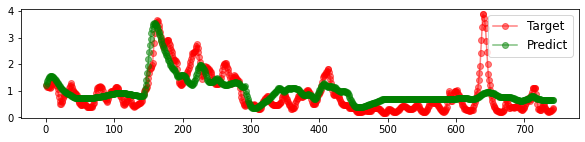

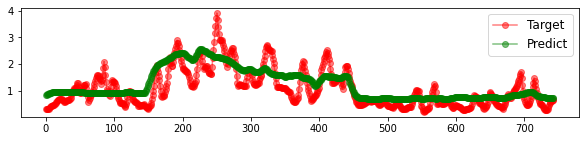

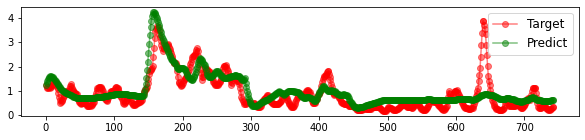

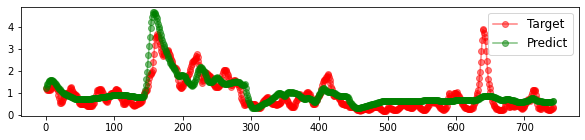

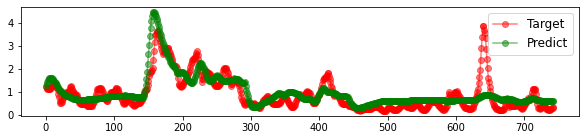

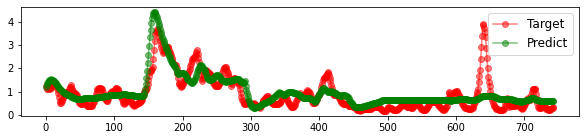

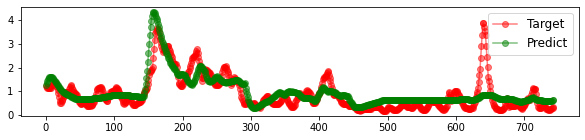

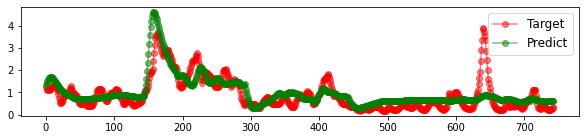

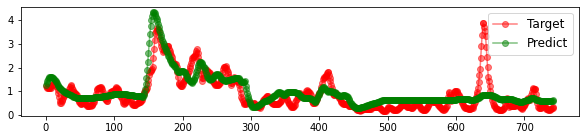

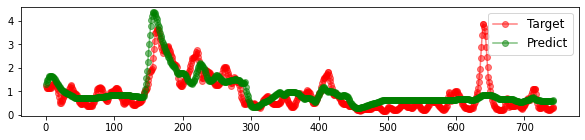

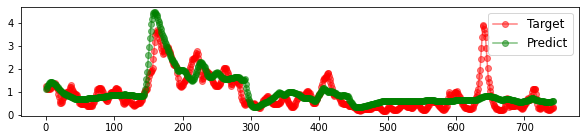

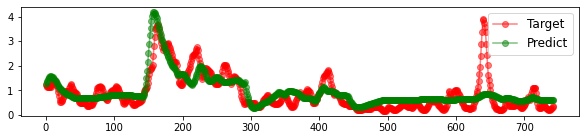

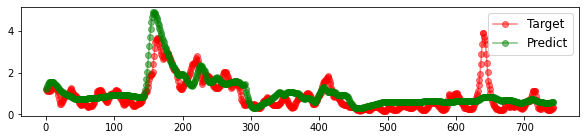

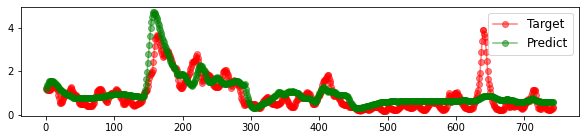

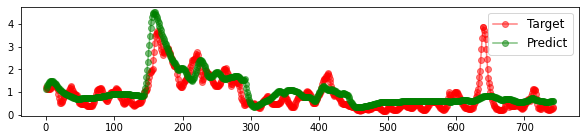

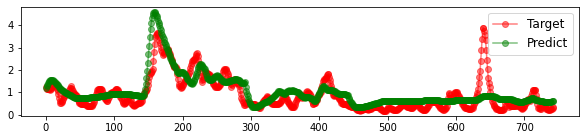

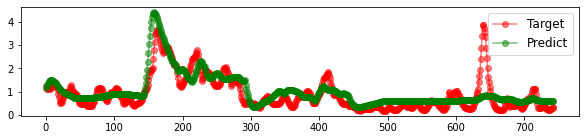

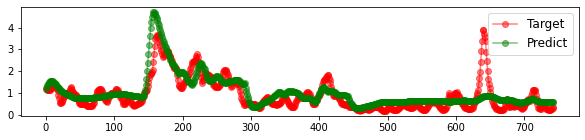

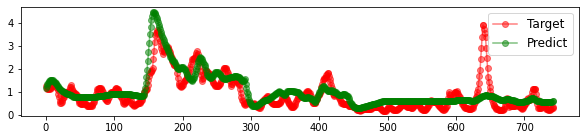

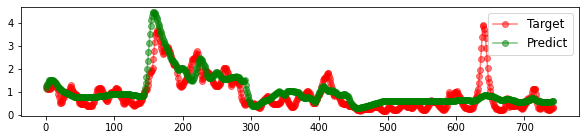

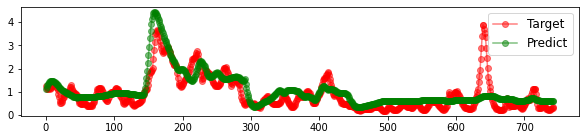

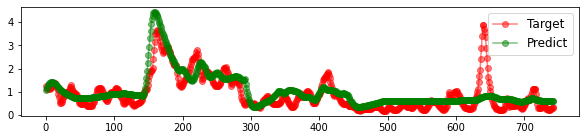

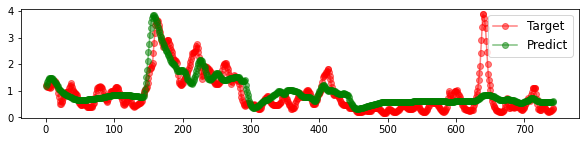

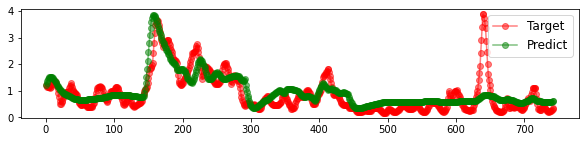

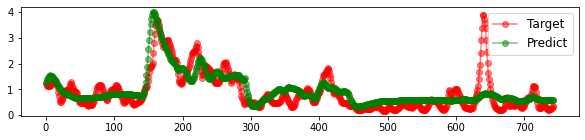

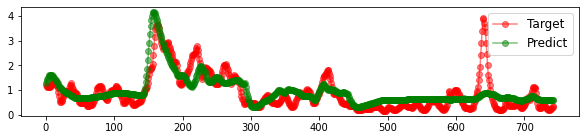

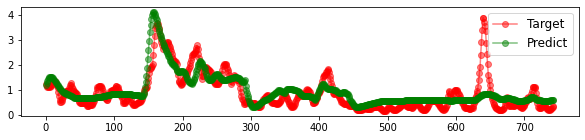

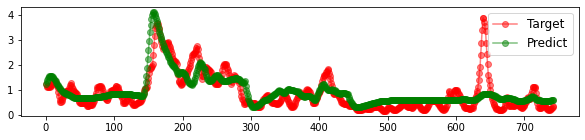

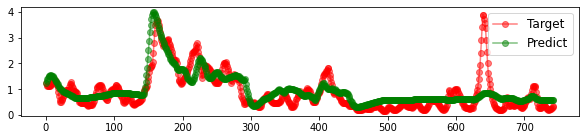

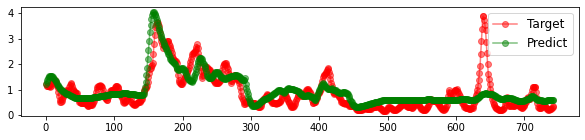

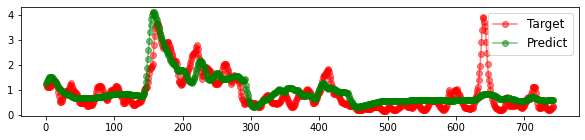

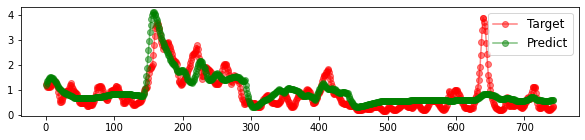

In [22]:
#test model
bnums=np.arange(1,8)
modeltestloss=[]
for gg in range(len(bnums)):
    bnum = str(gg+1) #batch number
    for ii in range(10):
        modelname=str(ii+1)
        tempmodel = ModelSemiSL3d1()
        tempmodel.load_state_dict(torch.load\
            ('./out/20210929_v4_ModelSemiSL3d1_ventral_upandlow_bnum_'+bnum+'_seed_'+modelname+'_weight_8'+'.pth'))
        tempmodel=tempmodel.to(device_cpu)
        CC,_=model_test(tempmodel,test_loader,device_cpu,sky_bg_mean_f,use_pad0_sti=False)
        modeltestloss.append(CC)

torch.cuda.empty_cache()
modeltestloss=np.array(modeltestloss).reshape(len(bnums),10)
print (modeltestloss)
print (np.mean(modeltestloss,axis=1))

In [24]:
#fitting goodness for conv0, for all weights and seeds
bnums=np.arange(1,8)
r2_ss=[]
seeds=np.arange(1,11)
width,height=9,9
for bnum in bnums:
    bnum = str(bnum)
    conv1_ss_s=[]
    r2_s=[]
    for seed in seeds:
        seed = str(seed)
        tempmodel= ModelSemiSL3d1()
        tempmodel.load_state_dict(torch.load\
            ('./out/20210929_v4_ModelSemiSL3d1_ventral_upandlow_bnum_'+bnum+'_seed_'+seed+'_weight_8'+'.pth'))
        tempmodel=tempmodel.to(device_cpu)
        conv1_ss=tempmodel.conv1_ss.cpu().data.numpy() #print (conv1_ss.shape) # (16, 2, 1, 9, 9)
        conv1_ss_s.append(conv1_ss)
    conv1_ss_s=np.array(conv1_ss_s)
    conv1_ss_s=np.reshape(conv1_ss_s,(-1,width*height))
    #
    for ii in range(len(conv1_ss_s)):
        fit_2dgaussian=Fit_2dGaussian(conv1_ss_s[ii],(width,height))
        fit_2dgaussian.fit()
        r2_s.append(fit_2dgaussian.cal_r2())
    r2_s=np.array(r2_s)
    r2_ss.append(r2_s)
r2_ss=np.array(r2_ss)
print (r2_ss.shape)

/usr/local/lib/python3.8/dist-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(7, 320)


### RFs and predictions for less training data

#### lossweights=[0.4]

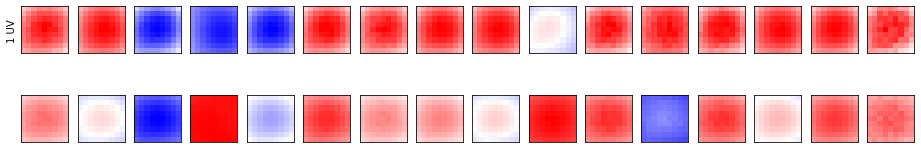

In [60]:
bnum = 2 # batch number 15
seed = 1 # seed

tempmodel= ModelSemiSL3d1()
tempmodel.load_state_dict(torch.load\
            ('./out/20210929_v4_ModelSemiSL3d1_ventral_upandlow_bnum_'+str(bnum)+'_seed_'+str(seed)+'_weight_8'+'.pth'))
tempmodel=tempmodel.to(device_cpu)
conv1_ss=tempmodel.conv1_ss.cpu().data.numpy() 
#print (conv1_ss.shape) # (32, 2, 1, 9, 9)
#nrows=int(conv1_ss.shape[0]/8)
ncols=conv1_ss.shape[0]
fig, axes = plt.subplots(nrows=2, ncols=ncols,figsize=(ncols,3))
for ii in range(ncols): 
    tempmax=np.max(np.abs(conv1_ss[ii]))
    axes[0,ii].imshow(conv1_ss[ii,0,0,:,:],vmin=-tempmax,vmax=tempmax,cmap='bwr')
    if ii==0:
        axes[0,ii].set_ylabel('{:} UV'.format(modelname))
    axes[0,ii].grid(False)#axes[ii,jj].axis('tight')
    axes[0,ii].set_xticks([])
    axes[0,ii].set_yticks([])
    axes[1,ii].imshow(conv1_ss[ii,1,0,:,:],vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[1,ii].grid(False) #axes[ii,jj].axis('tight')
    axes[1,ii].set_xticks([])
    axes[1,ii].set_yticks([])

(86, 2, 50, 36, 32)


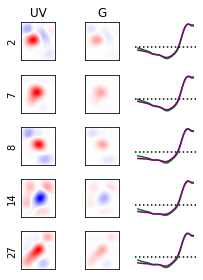

In [61]:
# save svd results of example neuronal RFs
nt = 50 # time lag
ny = 36
nx = 32
dims = [nt, ny, nx]
#
bnum = 2 # batch number 15
seed = 1 # seed
tempmodel= ModelSemiSL3d1()
tempmodel.load_state_dict(torch.load\
            ('./out/20210929_v4_ModelSemiSL3d1_ventral_upandlow_bnum_'+str(bnum)+'_seed_'+str(seed)+'_weight_8'+'.pth'))
tempmodel=tempmodel.to(device_cpu)
conv1_st_weight  =tempmodel.conv1_st.weight.data.clone().detach()
conv1_st_bias  =tempmodel.conv1_st.bias.data.clone().detach()
conv1_ss  =tempmodel.conv1_ss.data.clone().detach()
conv1_ss_bias   =tempmodel.conv1_ss_bias.data.clone().detach()
fc1_weight=tempmodel.fc1.weight.data.clone().detach()
fc1_bias  =tempmodel.fc1.bias.data.clone().detach()
tempmodel= ModelSemiSL3d1_copy(conv1_st_weight,conv1_st_bias,conv1_ss,conv1_ss_bias,fc1_weight,fc1_bias)
tempmodel=tempmodel.to(device_cpu)
RF_fl=vis_model_fl_3d(tempmodel,device_cpu,(1,2,nt,ny,nx))
RF_fl_np=RF_fl.cpu().data.numpy() #output shape (50,2,28,28)
print (RF_fl_np.shape)
#nums_eg=np.arange(len(RF_fl_np))
#
#plot RFs
nums_eg=[2,7,8,14,27]  #np.arange(len(RF_fl_np)) [63,8,33]
nrows=len(nums_eg)
fig,axes = plt.subplots(nrows=nrows,ncols=3,figsize=(3,int(nrows/1.1)))
for ii in range(nrows):
    [sRF_UV, tRF_UV]=mySVD(RF_fl_np[nums_eg[ii],0], dims)
    [sRF_G, tRF_G]=mySVD(RF_fl_np[nums_eg[ii],1], dims)
    tempmax=np.max(np.abs([sRF_UV,sRF_G]))
    axes[ii,0].imshow(sRF_UV,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,0].set_xticks([])
    axes[ii,0].set_yticks([])
    axes[ii,0].set_ylabel('%d' %(nums_eg[ii]))
    axes[ii,1].imshow(sRF_G,vmin=-tempmax,vmax=tempmax,cmap='bwr')
    axes[ii,1].set_xticks([])
    axes[ii,1].set_yticks([])
    axes[ii,2].plot(tRF_G,color='g',linestyle='-')
    axes[ii,2].plot(tRF_UV,color='purple',linestyle='-')
    axes[ii,2].axhline(y=0,color='k',linestyle=':')
    axes[ii,2].spines['left'].set_visible(False)
    axes[ii,2].spines['bottom'].set_visible(False)
    axes[ii,2].spines['right'].set_visible(False)
    axes[ii,2].spines['top'].set_visible(False)
    axes[ii,2].set_xticks([])
    axes[ii,2].set_yticks([])
axes[0,0].set_title('UV')
axes[0,1].set_title('G')
plt.tight_layout()

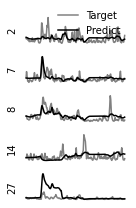

In [68]:
#plot prediction results for example neurons
bnum = 2 # batch number 15
seed = 1 # seed
tempmodel= ModelSemiSL3d1()
tempmodel.load_state_dict(torch.load\
            ('./out/20210929_v4_ModelSemiSL3d1_ventral_upandlow_bnum_'+str(bnum)+'_seed_'+str(seed)+'_weight_8'+'.pth'))

tempmodel=tempmodel.to(device_cpu)
tempmodel=tempmodel.eval()
(x,y,z)=test_loader
x=torch.from_numpy(x).float()
b_x = x.to(device_cpu) 
z=z/255.0
z[:,0,:,:]=z[:,0,:,:]-sky_bg_mean_f[0]
z[:,1,:,:]=z[:,1,:,:]-sky_bg_mean_f[1]
z = z[:,:,np.newaxis,:,:]
b_z = torch.from_numpy(z).float().to(device_cpu)
with torch.no_grad():
    encoded,_,_ = tempmodel(b_x,b_z)
encoded_np=encoded.cpu().data.numpy()

encoded_np=encoded_np[test_loader[0].shape[2]-1:,:] #use_pad0_sti=False
y=y[test_loader[0].shape[2]-1:,:] #use_pad0_sti=False
#
nums_eg=[2,7,8,14,27]
nrows=len(nums_eg)
#nrows=encoded_np.shape[1]
testccs=np.zeros((nrows))
testpVs=np.zeros((nrows))
fig,axes=plt.subplots(nrows=nrows,ncols=1,figsize=(2,int(nrows/1.5)))
for ii in range(nrows):
    testcc,testpvalue=pearsonr(encoded_np[:,nums_eg[ii]], y[:,nums_eg[ii]])
    testccs[ii]=testcc
    testpVs[ii]=testpvalue
    axes[ii].plot(y[:,nums_eg[ii]],color='gray',linestyle='-',label='Target')
    axes[ii].plot(encoded_np[:,nums_eg[ii]],color='k',linestyle='-',label='Predict')
    if ii == 0:
        axes[ii].legend(loc='best',frameon=False)
        #axes[ii].set_title('UVGnoise_30Hz')
    #axes[ii].set_title('Neuron: {:}, CC: {:.2f}, p: {:.2f}'.format(ii,testcc,testpvalue))
    axes[ii].spines['left'].set_visible(False)
    axes[ii].spines['bottom'].set_visible(False)
    axes[ii].spines['right'].set_visible(False)
    axes[ii].spines['top'].set_visible(False)
    axes[ii].set_xticks([])
    axes[ii].set_yticks([])
    #axes[ii].set_xlabel('CC: %.2f, pV: %.2f' %(testcc,testpvalue))
    axes[ii].set_ylabel('%d' %(nums_eg[ii]))
plt.tight_layout()